参考サイト
http://keik-117.hatenablog.com/entry/2016/07/01/185011

In [29]:
import pyaudio #https://www.lfd.uci.edu/~gohlke/pythonlibs/#pyaudioからダウンロードしてインストール(ネット経由のpipはうまくいかない)
               #＋VS2017 CrossTTool cmdでpip実行（C++コンパイラcl.exeが必要なため）
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.io.wavfile as wav
from scipy.stats import kurtosis
from IPython.display import display, Audio
from scipy import signal
%matplotlib inline

In [2]:
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
CHUNK = 1024
RECORD_SECONDS = 2

In [3]:
# 録音用の関数を定義
def recording():
    audio = pyaudio.PyAudio()

    # start Recording
    stream = audio.open(format=FORMAT,
                        channels=CHANNELS,
                        rate=RATE, input=True,
                        frames_per_buffer=CHUNK)
    frames = []
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    stream.stop_stream()
    stream.close()
    audio.terminate()
    return frames

# STEP1
２つの独立音源 s1 ,  s2 を用意する。  
録音するか、または録音済みの音声ファイルを読み込んで、２つの独立音源 s1 ,  s2 の標本配列を得る。

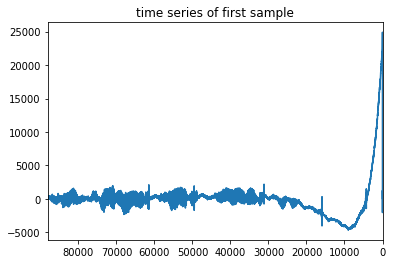

In [5]:
##record and write
# s1 = np.fromstring(b''.join(recording()), np.int16)
# wav.write('data/kurodasan_high.wav', RATE, s1)

# read second sample
# s1_temp = wav.read('sato_sony.wav')[1]
s1 = wav.read('data/kurodasan.wav')[1]
# s1 = s1_temp[2000:20000,0].reshape(-1)
# s1 = wav.read('dl1.wav')[1]

plt.xlim(len(s1))
plt.title('time series of first sample')
plt.plot(s1)

display(Audio(s1, rate=RATE))

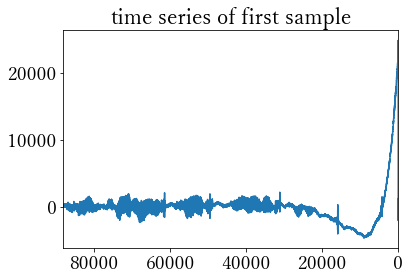

In [116]:
##record and write
# s2 = np.fromstring(b''.join(recording()), np.int16)
# wav.write('data/kurodasan_high.wav', RATE, s2)

# read second sample
# s2_temp = wav.read('sato_sony.wav')[1]
s2 = wav.read('data/shimamurasan.wav')[1]
# s2 = s2_temp[2000:20000,0].reshape(-1)
# s2 = wav.read('dl2.wav')[1]

plt.xlim(len(s1))
plt.title('time series of first sample')
plt.plot(s1)

display(Audio(s1, rate=RATE))

# STEP2
s1 ,  s2 の音量をランダムな強さ  R によって加法合成した２つの合成音源 x1 ,  x2 を得る。

合成する各音源の音量倍率 R:
[[ 0.95  0.78]
 [ 0.31  0.04]]


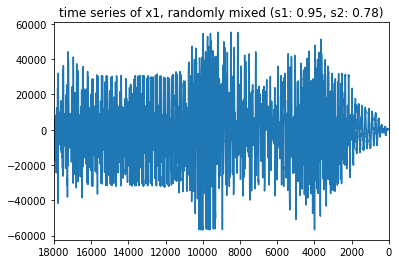

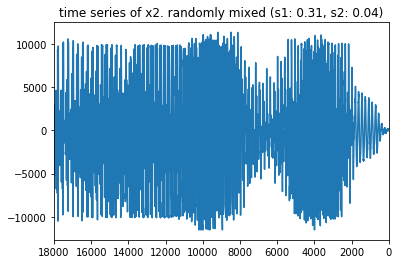

In [7]:
# Randomly mix
R = np.random.rand(4).reshape(2, 2)

np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
print('合成する各音源の音量倍率 R:\n{}'.format(R))

x1, x2 = np.dot(R, (s1, s2))

plt.figure()
plt.xlim(len(x1))
plt.title('time series of x1, randomly mixed (s1: {0:.2f}, s2: {1:.2f})'.format(R[0,0], R[0,1]))
plt.plot(x1)

display(Audio(x1, rate=RATE))

plt.figure()
plt.title('time series of x2. randomly mixed (s1: {0:.2f}, s2: {1:.2f})'.format(R[1,0], R[1,1]))
plt.xlim(len(x2))
plt.plot(x2)

display(Audio(x2, rate=RATE))

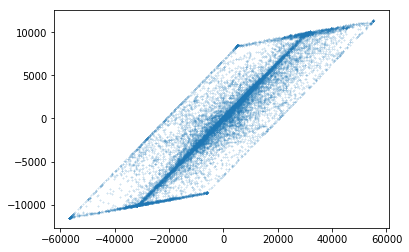

In [8]:
plt.scatter(x1, x2, s=1, marker='x', alpha=0.2)

# STEP3
ICA の手法に基づいて x1 ,  x2 から独立音源 s1 ,  s2 を推定して音源を分離し、分離音源 s1^ ,  s2^ を得る

Text(0, 0.5, 'kurtosis')

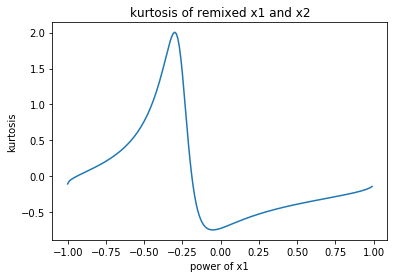

In [9]:
# 音量レベル　[-1, 1] の区間における尖度 kurtosis 分布を計算する
def kurtosis_of_mixture(p, x1, x2):
    sample1 = x1[::10]
    sample2 = x2[::10]
    p2 = np.sqrt(1 - p ** 2)
    mixed_series = p * sample1 + p2 * sample2
    m2 = np.std(mixed_series) ** 2
    m4 = np.mean([x ** 4 for x in mixed_series])
    return m4 / (m2 ** 2) - 3  # fix to Fisher's definition with -3

p_array = np.arange(-1,1,0.01)
k_array = [kurtosis_of_mixture(item, x1, x2) for item in p_array]

plt.plot(p_array, k_array)
plt.title('kurtosis of remixed x1 and x2')
plt.xlabel('power of x1')
plt.ylabel('kurtosis')

Text(0, 0.5, 'kurtosis')

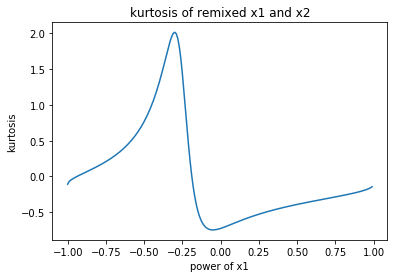

In [10]:
# SciPy 版
# [-1, 1] の区間における尖度 kurtosis を計算する
def kurtosis_of_mixture(p, x1, x2):
    sample1 = x1[::10]
    sample2 = x2[::10]
    p2 = np.sqrt(1 - p ** 2)
    mixed_series = p * sample1 + p2 * sample2
    return kurtosis(mixed_series)

p_array = np.arange(-1,1,0.01)
k_array = [kurtosis_of_mixture(item, x1, x2) for item in p_array]

plt.plot(p_array, k_array)
plt.title('kurtosis of remixed x1 and x2')
plt.xlabel('power of x1')
plt.ylabel('kurtosis')

In [11]:
# 尖度の最大・最小値を用いて、合成音源 x1, x2 の独立性が最大となるように行列変換する
k_max = max(k_array)
k_argmax = p_array[k_array.index(k_max)]
k_min = min(k_array)
k_argmin = p_array[k_array.index(k_min)]

print('''max(k): {:.2f}, argmax(k): {:.2f},
min(k): {:.2f}, argmin(k): {:.2f}'''.format(
        k_max, k_argmax,
        k_min, k_argmin))

c = np.array((
            (k_argmax, np.sqrt(1 - k_argmax ** 2)), 
            (k_argmin, np.sqrt(1 - k_argmin ** 2))
        ))

sep1, sep2 = np.dot(c, np.array((x1, x2)))

print('分離音源 sep1')
display(Audio(sep1, rate=RATE))
print('分離音源 sep2')
display(Audio(sep2, rate=RATE))

max(k): 2.02, argmax(k): -0.30,
min(k): -0.75, argmin(k): -0.05
分離音源 sep1


分離音源 sep2


分離音源 s1^ ,  s2^ の散布図を描いてみる。  
x1 ,  x2 の散布図のように、明らかな相関のある散布図に比べ、 s1 ,  s2 の散布図のような上下左右対称に近い散布図に近づいていることが想定される

Text(0, 0.5, 'sep2')

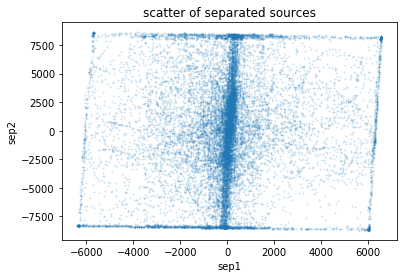

In [12]:
plt.title('scatter of separated sources')
plt.scatter(sep1, sep2, s=1, marker='x', alpha=0.2)
plt.xlabel('sep1')
plt.ylabel('sep2')

#  STEP4 ここからが本題

得られた音声データを周波数領域に変換

In [11]:
def FFT_Func(data,StartCellNum,CalLength,WindowNum):
    #FFTをかけるデータの設定
    Caldata = data[StartCellNum:StartCellNum + CalLength]
    #窓関数の選択：WindowNum →0: ハニング窓,1:ハミング窓,Others:ブラックマン窓 
    if WindowNum == 0:
        w = signal.hann(CalLength)
    elif WindowNum == 1:
        w = signal.hamming(CalLength)
    else:
        w = signal.blackman(CalLength)
    ##FFT計算
    FFTReturn =np.fft.fft(w*Caldata)
    
    return FFTReturn

In [26]:
def iFFT_Func(data,StartCellNum,CalLength,WindowNum):
    #FFTをかけるデータの設定
    Caldata = data[StartCellNum:StartCellNum + CalLength]
    #窓関数の選択：WindowNum →0: ハニング窓,1:ハミング窓,Others:ブラックマン窓 
    if WindowNum == 0:
        w = signal.hann(CalLength)
    elif WindowNum == 1:
        w = signal.hamming(CalLength)
    else:
        w = signal.blackman(CalLength)
    ##iFFT計算
    iFFTReturn =np.fft.ifft(w*Caldata)
    
    return iFFTReturn

In [117]:
#解析するデータの設定
data = s2
#チューニングパラメータの設定
StartCellNum = 30000
CalLength = 20000
WindowNum = 0
##FFTの実行
FFTData = FFT_Func(data,StartCellNum,CalLength,WindowNum)
#絶対値(FFTAmp)に変換
FFTAmp = np.abs(FFTData)

FFTをかけたデータの確認

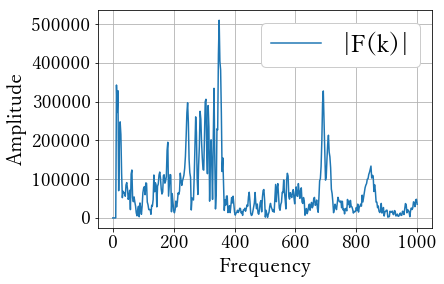

In [118]:
#周波数間隔計算のための値設定
N = CalLength         # サンプル数
dt = 1/48000          # サンプリング間隔
voice_lim_low = 20    # 人の声周波数最小値
voice_lim_high = 1000 # 人の声周波数最大値
#X軸の設定（人の発声可能周波数まで）
voice_freq = np.linspace(0,voice_lim_high,int((voice_lim_high)/(1/dt)*N)) # 周波数
#直流成分を0にする(5は設計パラメータ：適宜変更)
FFTAmp[:5] = 0
plt.plot(voice_freq,FFTAmp[:int(voice_lim_high/(1/dt)*N)], label='|F(k)|')
plt.xlabel('Frequency', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
plt.grid()
leg = plt.legend(loc=1, fontsize=25)
leg.get_frame().set_alpha(1)
plt.show()

#  STEP5

ケプストラム空間でLPF処理

In [119]:
#ケプストラム変換のためのデータ設定
CalLengthKps,col  = np.shape(FFTData.reshape(-1,1))
StartCellNumKps = 0
WindowNumKps = 0
# ケプストラム変換（FFTしたデータにFFTをかける）
KpsData = FFT_Func(FFTData,StartCellNumKps,CalLengthKps,WindowNumKps)
KpsAmp = np.abs(KpsData)

ケプストラム変換したデータをフィルタリングしたデータを確認

In [129]:
#フィルタリング設計パラメータ
FltNum = 5000
#LPFの実施:FltNum以降の高周波成分をcut
FltKpsData = np.copy(KpsData)
FltKpsData[FltNum:] = 0

フィルタリングの結果を確認

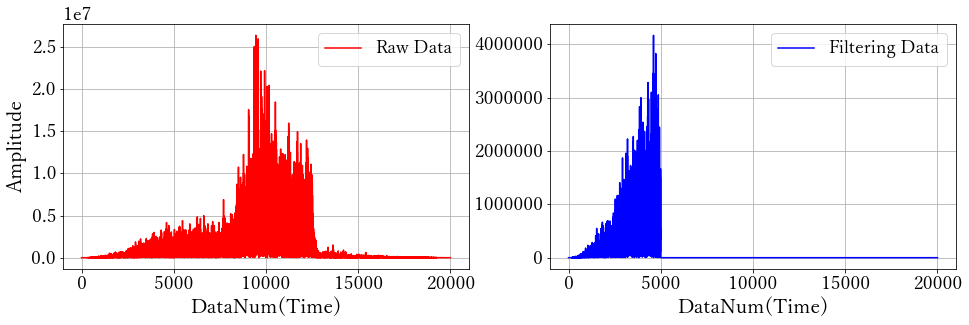

In [130]:
plt.rcParams["font.size"] = 18
fig = plt.figure(figsize=(16,4.5))
font = {'family':'Yu Mincho'}
matplotlib.rc('font', **font) 
plt.subplot(1,2,1)
plt.plot(np.abs(KpsData),label = 'Raw Data',color = 'r')
plt.xlabel('DataNum(Time)', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
plt.grid()
# plt.ylim([1300,1600])
# plt.xlim([-1,7])
plt.legend()
plt.subplot(1,2,2)
plt.plot(np.abs(FltKpsData),label = 'Filtering Data',color = 'b')
plt.xlabel('DataNum(Time)', fontsize=20)
# plt.ylabel('Amplitude', fontsize=20)
plt.grid()
plt.legend()

ifftをかけて周波数領域に再変換

In [131]:
# ケプストラムを周波数領域に再変換（FFTをFFTしたデータにiFFTをかける）
FltFFTData = iFFT_Func(FltKpsData,StartCellNumKps,CalLengthKps,WindowNumKps)
FltFFTAmp = np.abs(FltFFTData)
# plt.plot(voice_freq,ifft_Kps[:int(voice_lim_high/(1/dt)*N)])

フィルタリング結果を確認

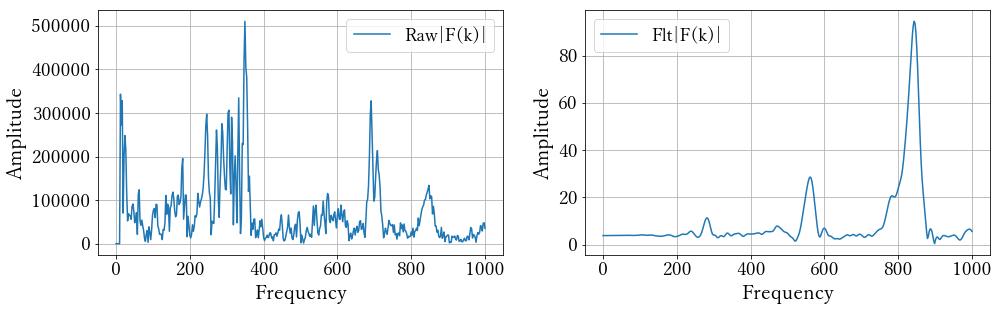

In [132]:
fig = plt.figure(figsize=(16,4.5))
plt.subplot(1,2,1)
plt.plot(voice_freq,FFTAmp[:int(voice_lim_high/(1/dt)*N)], label='Raw|F(k)|')
plt.xlabel('Frequency', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
plt.grid()
plt.legend()
plt.subplot(1,2,2)
plt.plot(voice_freq,FltFFTAmp[:int(voice_lim_high/(1/dt)*N)], label='Flt|F(k)|')
plt.xlabel('Frequency', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
plt.grid()
plt.legend()

#  STEP6

自己相関を用いて基本振動数を算出

In [133]:
def AutoCorrelation(ACData,DataLength):
    ac_data = ACData[:DataLength]-np.mean(ACData[:DataLength])
    corr = np.correlate(ac_data, ac_data, "full")
    return corr 

In [134]:
def pick_peak(data):#ピークを算出：左右の点より大きい点を抽出
	peaks_val = []
	peaks_index = []
	for i in range(2, data.size):
		if data[i-1] - data[i-2] >= 0 and data[i] - data[i-1] < 0:
			peaks_val.append(data[i-1])
			peaks_index.append(i-1)
	max_index = peaks_val.index(max(peaks_val))
	return peaks_index[max_index]

自己相関の計算

In [138]:
#自己相関パラメータ設定
DataLength = int(voice_lim_high/(1/dt)*N)#人の声最大周波数まで

#自己相関を計算
# 1:ケプストラム変換考慮ver
ACDataFlt = FltFFTAmp
CorrFlt = AutoCorrelation(ACDataFlt,DataLength)
# 2:ケプストラム変換考慮しないver
ACData = FFTAmp
Corr = AutoCorrelation(ACData,DataLength)

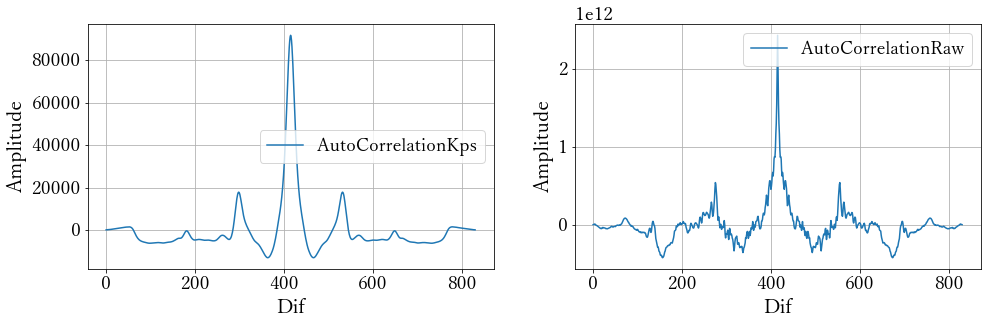

In [139]:
# plt.plot(Corr, label='AutoCorrelation')
# plt.xlabel('Dif',fontsize=20)
# plt.ylabel('Amplitude', fontsize=20)
# plt.grid()
# plt.legend()
fig = plt.figure(figsize=(16,4.5))
plt.subplot(1,2,1)
plt.plot(CorrFlt, label='AutoCorrelationKps')
plt.xlabel('Dif',fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
plt.grid()
plt.legend()
plt.subplot(1,2,2)
plt.plot(Corr, label='AutoCorrelationRaw')
plt.xlabel('Dif',fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
plt.grid()
plt.legend()

基本振動数の計算

In [140]:
#２番目のピークを算出※1番目のピークはずれ（基本振動数）＝０
ScndPeakFlt = pick_peak(CorrFlt[(DataLength - 1):])
ScndPeak = pick_peak(Corr[(DataLength - 1):])
#周波数成分に変換
FundFreqFlt = ScndPeakFlt * (1/dt)/N
FundFreq = ScndPeak * (1/dt)/N
print("基本振動数Ksp =",FundFreqFlt,"Hz")
print("基本振動数 =",FundFreq,"Hz")

基本振動数Ksp = 280.8 Hz
基本振動数 = 16.8 Hz


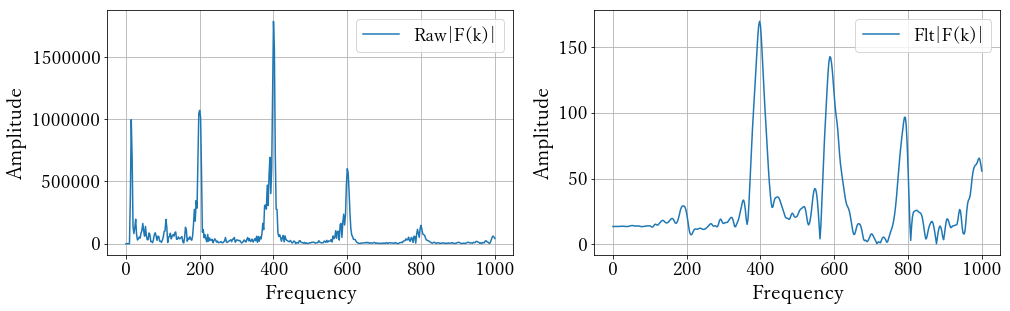

In [109]:
#振動数確認用（上のプロットを再度描画）
fig = plt.figure(figsize=(16,4.5))
plt.subplot(1,2,1)
plt.plot(voice_freq,FFTAmp[:int(voice_lim_high/(1/dt)*N)], label='Raw|F(k)|')
plt.xlabel('Frequency', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
plt.grid()
plt.legend()
plt.subplot(1,2,2)
plt.plot(voice_freq,FltFFTAmp[:int(voice_lim_high/(1/dt)*N)], label='Flt|F(k)|')
plt.xlabel('Frequency', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
plt.grid()
plt.legend()